<a href="https://colab.research.google.com/github/NirantK/Hinglish/blob/all_berts/DistilBERTBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

In [0]:
# !cp drive/My\ Drive/Hinglish/clean_data/train_lm1.txt .
# !cp drive/My\ Drive/Hinglish/clean_data/dev_lm1.txt .
# !cp drive/My\ Drive/Hinglish/clean_data/test_lm1.txt .
# !cp drive/My\ Drive/run_language_modeling.py .

In [0]:
# !head train_lm1.txt

In [0]:
# !python run_language_modeling.py --output_dir=distilBertclean --model_type=distilbert --model_name_or_path=distilbert-base-cased --do_train --train_data_file=train_lm1.txt --do_eval --eval_data_file=dev_lm1.txt --mlm  --num_train_epochs 10 --save_total_limit 2 --overwrite_output_dir

In [0]:
# !cp -r distilBertclean drive/My\ Drive/

In [0]:
import pandas as pd
train_df = pd.read_json("drive/My Drive/Hinglish/clean_data/train1.json")
test_df = pd.read_json("drive/My Drive/Hinglish/clean_data/test1.json")
sentences = train_df['clean_text']
labels = train_df['sentiment']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

In [0]:
import torch
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
    device = torch.device("cuda")
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
# !cp -r output drive/My\ Drive/

In [0]:
from transformers import DistilBertTokenizer

# Load the DistilBERT tokenizer.
print('Loading DistilBERT tokenizer...')
tokenizer= DistilBertTokenizer.from_pretrained("drive/My Drive/distilBert6")
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")

print (tokenized_texts[0])
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 200

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning DistilBERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig


Loading DistilBERT tokenizer...
Tokenize the first sentence:
['I', 'CA', '##N', '’', 'T', 'E', '##VE', '##N', 'B', '##EL', '##IE', '##VE', 'T', '##HA', '##T', 'I', '’', 'V', '##E', 'GO', '##T', 'P', '##IC', '##TU', '##RE', '##S', 'W', '##IT', '##H', 'MI', '##LE', '##Y', 'F', '##UC', '##K', '##ING', 'C', '##Y', '##R', '##US', 'T', '##H', '##IS', 'IS', 'A', 'F', '##UC', '##K', '##ING', 'DR', '##EA', '##M', 'CO', '##ME', 'T', '##R', '##UE', ':', 'loudly', '_', 'crying', '_', 'face', ':', 'I', 'L', '##O', '##VE', 'YOU', 'M', '##OR', '##E', 'T', '##H', '…']
Original:    I CAN ’ T EVEN BELIEVE THAT I ’ VE GOT PICTURES WITH MILEY FUCKING CYRUS THIS IS A FUCKING DREAM COME TRUE :loudly_crying_face: I LOVE YOU MORE TH …  
Token IDs: [101, 146, 8784, 2249, 787, 157, 142, 17145, 2249, 139, 21678, 17444, 17145, 157, 11612, 1942, 146, 787, 159, 2036, 27157, 1942, 153, 9741, 27074, 16941, 1708, 160, 12150, 3048, 26574, 17516, 3663, 143, 21986, 2428, 15740, 140, 3663, 2069, 13329, 157, 3048, 6258, 19

Using TensorFlow backend.


In [0]:
config = DistilBertConfig.from_json_file('./drive/My Drive/distilBert6/config.json')

In [0]:
config.attention_probs_dropout_prob=0.6
config.do_sample=True
config.hidden_dropout_prob=0.6
config.num_labels=3
config.dropout=0.5

In [0]:
config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.6,
  "bos_token_id": 0,
  "dim": 768,
  "do_sample": true,
  "dropout": 0.5,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.6,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "num_beams": 1,
  "num_labels": 3,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "repetition_penalty": 1.0,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "temperature": 1.0,
  "tie_weights_": tr

In [0]:

# Load DistilBertForSequenceClassification, the pretrained DistilBERT model with a single 
# linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained(
    "drive/My Drive/distilBert6", # Use the 12-layer DistilBERT model, with an uncased vocab.
    # num_labels = 3, # The number of output labels--2 for binary classification. 
    # output_attentions = False, # Whether the model returns attentions weights.
    # output_hidden_states = False, # Whether the model returns all hidden-states.
    config=config
)

# Tell pytorch to run this model on the GPU.
model.cuda()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.5, inplace=False)
       

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 8e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_cosine_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 100, # Default value in run_glue.py
                                            num_training_steps = total_steps)

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_prf(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_recall_fscore_support(labels_flat, pred_flat, labels =[0,1,2],average='macro')

from sklearn.metrics import f1_score

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []



The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (28996, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [0]:
from sklearn.metrics import precision_recall_fscore_support


In [0]:
def run_valid():
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_p =0
  eval_r =0
  eval_f1 =0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and
      # speeding up validation
      with torch.no_grad():        

          # Forward pass, calculate logit predictions.
          # This will return the logits rather than the loss because we have
          # not provided labels.
          # token_type_ids is the same as the "segment ids", which 
          # differentiates sentence 1 and 2 in 2-sentence tasks.
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids,  
                          attention_mask=b_input_mask)
      
      # Get the "logits" output by the model. The "logits" are the output
      # values prior to applying an activation function like the softmax.
      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Calculate the accuracy for this batch of test sentences.
      tmp_eval_accuracy = flat_accuracy(logits,label_ids)
      temp_eval_f1 = flat_prf(logits, label_ids)

      # Accumulate the total accuracy.
      eval_accuracy += tmp_eval_accuracy
      eval_p += temp_eval_f1[0]
      eval_r += temp_eval_f1[1]
      eval_f1 += temp_eval_f1[2]

      # Track the number of batches
      nb_eval_steps += 1

  # Report the final accuracy for this validation run.
  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print(f"  Precision, Recall F1: {eval_p/nb_eval_steps}, {eval_r/nb_eval_steps}, {eval_f1/nb_eval_steps}")
  print("  Validation took: {:}".format(format_time(time.time() - t0)))
  # Report progress.
  

In [0]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        if step % 40 == 0 and not step == 0:
            run_valid()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    383.    Elapsed: 0:00:12.

Running Validation...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Accuracy: 0.44
  Precision, Recall F1: 0.5508448126582172, 0.43720744093521113, 0.3958479365090194
  Validation took: 0:00:04
  Batch    80  of    383.    Elapsed: 0:00:28.

Running Validation...
  Accuracy: 0.56
  Precision, Recall F1: 0.5801507897294131, 0.5554872288627417, 0.5485286721659228
  Validation took: 0:00:04
  Batch   120  of    383.    Elapsed: 0:00:45.

Running Validation...
  Accuracy: 0.54
  Precision, Recall F1: 0.6099727039679521, 0.5440668004792492, 0.5347846057550465
  Validation took: 0:00:04
  Batch   160  of    383.    Elapsed: 0:01:01.

Running Validation...
  Accuracy: 0.58
  Precision, Recall F1: 0.5976065670662112, 0.5756890750734798, 0.5629096620007736
  Validation took: 0:00:04
  Batch   200  of    383.    Elapsed: 0:01:17.

Running Validation...
  Accuracy: 0.54
  Precision, Recall F1: 0.5871103840733624, 0.570439332922233, 0.5044109682857811
  Validation took: 0:00:04
  Batch   240  of    383.    Elapsed: 0:01:33.

Running Validation...
  Accuracy: 0.6

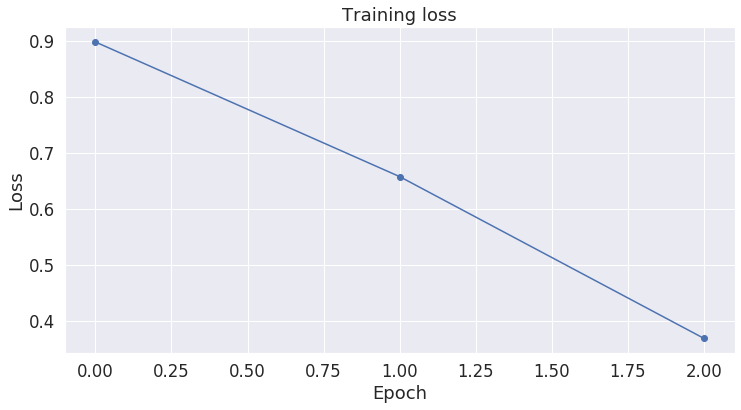

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
final_test_df = pd.read_json("drive/My Drive/Hinglish/clean_data/train1.json")
sentences = final_test_df['clean_text']
# Report the number of sentences.

# Create sentence and label lists
# sentences = df.sentence.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on valid set

print('Predicting labels for {:,} valid sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')


# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
proba = [item for sublist in predictions for item in sublist]
preds = np.argmax(proba, axis=1).flatten()

output = le.inverse_transform(flat_predictions.tolist())
output_df = pd.DataFrame({
    'Uid':list(final_test_df['uid']),
    'Sentiment':output,
    'clean_text':list(final_test_df['clean_text'])
})

Predicting labels for 13,600 valid sentences...
    DONE.


In [0]:
proba = [item for sublist in predictions for item in sublist]
preds = np.argmax(proba, axis=1).flatten()
full_output = output_df
full_output['proba_negative'] = pd.DataFrame(proba)[0]
full_output['proba_neutral'] = pd.DataFrame(proba)[1]
full_output['proba_positive'] = pd.DataFrame(proba)[2]
full_output['actual'] = final_test_df['sentiment']
full_output

,Uid,Sentiment,clean_text,proba_negative,proba_neutral,proba_positive,actual
0,1379,positive,I CAN ’ T EVEN BELIEVE THAT I ’ VE GOT PICTU...,-1.919072,-0.257504,1.752073,positive
1,35969,positive,PakistanZindabad PakArmyZindabad Gumnam h...,-2.526149,-0.651931,2.955244,positive
2,24314,neutral,Yar masla ye nai hai k log isko nahi chorei...,-1.831602,2.399457,-1.343211,neutral
3,12400,negative,Baap ki izzat beti k hathon me hoti hai r pr...,2.462616,-1.060204,-1.574207,negative
4,36030,neutral,Jhoot gali galoch hindu muslim ashlil andh b...,-0.221670,0.215242,-0.364505,positive
...,...,...,...,...,...,...,...
13595,13111,positive,Holding ur tongue so exhausting !!! Feeling ...,-0.532218,-0.427954,0.733901,negative
13596,4654,positive,Budget tu pass ho jaye ga . Har baar ki tarah...,-2.450695,-0.151102,2.115391,positive
13597,30610,positive,Congratulations all of you .. Bhot bhot badha...,-2.718532,-0.681583,3.153661,positive
13598,23584,positive,So sweet .. thank you soo much _ Awaaz _...,-3.031133,-0.395883,3.038612,positive


In [0]:
f1_score(full_output["Sentiment"], full_output["actual"], average="macro")

0.891265058221523

In [0]:
full_output.to_csv("drive/My Drive/DistilBERT_train2.csv")

In [0]:
import os
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
final_test_df = pd.read_json("drive/My Drive/Hinglish/clean_data/final_test1.json")
sentences = final_test_df['clean_text']
# Report the number of sentences.

# Create sentence and label lists
# sentences = df.sentence.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on valid set

print('Predicting labels for {:,} valid sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')


# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
proba = [item for sublist in predictions for item in sublist]
preds = np.argmax(proba, axis=1).flatten()

output = le.inverse_transform(flat_predictions.tolist())
output_df = pd.DataFrame({
    'Uid':list(final_test_df['uid']),
    'Sentiment':output,
    'clean_text':list(final_test_df['clean_text'])
})


proba = [item for sublist in predictions for item in sublist]
preds = np.argmax(proba, axis=1).flatten()
full_output = output_df
full_output['proba_negative'] = pd.DataFrame(proba)[0]
full_output['proba_neutral'] = pd.DataFrame(proba)[1]
full_output['proba_positive'] = pd.DataFrame(proba)[2]

full_output.to_csv("drive/My Drive/DistilBERT_test2.csv")

Predicting labels for 2,999 valid sentences...
    DONE.


In [0]:
!zip -r distilbert2.zip model_save
# from google.colab import files
# files.download("distilbert2.zip")

updating: model_save/ (stored 0%)
updating: model_save/pytorch_model.bin (deflated 8%)
updating: model_save/tokenizer_config.json (deflated 34%)
updating: model_save/special_tokens_map.json (deflated 40%)
updating: model_save/vocab.txt (deflated 49%)
updating: model_save/config.json (deflated 55%)


In [0]:
!cp distilbert2.zip drive/My\ Drive/models/